In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")  

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('ChurnCleaned.csv')

In [4]:
df = df.drop(columns=['Unnamed: 0', 'customerID'])

In [5]:
#Breacking the data into catogries for Processing

#All columns with categorical data
categorical = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
 'Contract','PaperlessBilling','PaymentMethod','AutomaticMethod']

#All columns with numerical data
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
#replacing values indicating if a customer churned for better readability later
df['Churn'] = df['Churn'].replace('No', 'Current')
df['Churn'] = df['Churn'].replace('Yes', 'Churned')

In [7]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}
for cat in categorical:
    label_encoders[cat] = LabelEncoder()
    df[cat] = label_encoders[cat].fit_transform(df[cat])
    names = label_encoders[cat].classes_.tolist()
   # print('Label encoder %s - values: %s' % (cat, names))
    categorical_feature_names.extend([cat + '_' + str(name) for name in names])

In [8]:
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

In [9]:
column_transf = make_column_transformer(
    (OneHotEncoder(),categorical),
    (StandardScaler(),numerical),
    remainder = 'passthrough')

In [10]:
pipe1 = make_pipeline(column_transf, (tree.DecisionTreeClassifier(max_depth=5, random_state=42)))
pipe2 = make_pipeline(column_transf,svm.SVC(random_state=42))
pipe3 = make_pipeline(column_transf,KNeighborsClassifier(n_neighbors=5))

pipe_dict= {0: 'DecisionTreeClassifier', 1: 'SVC', 2:'KNeighborsClassifier'}

pipelines = [pipe1, pipe2, pipe3]

In [11]:
x = df.drop('Churn',axis='columns')
y =  df['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

for i, pipe in enumerate(pipelines):
    pipe.fit(x_train,y_train)
    print('{} Test Accuracy {}:'.format(pipe_dict[i],pipe.score(x_test,y_test)))
    pred = pipe.predict(x_test)
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    print(" ")


DecisionTreeClassifier Test Accuracy 0.7936583057264552:
              precision    recall  f1-score   support

     Churned       0.62      0.62      0.62       574
     Current       0.86      0.86      0.86      1539

    accuracy                           0.79      2113
   macro avg       0.74      0.74      0.74      2113
weighted avg       0.79      0.79      0.79      2113

[[ 355  219]
 [ 217 1322]]
 
SVC Test Accuracy 0.8064363464268812:
              precision    recall  f1-score   support

     Churned       0.70      0.50      0.59       574
     Current       0.83      0.92      0.87      1539

    accuracy                           0.81      2113
   macro avg       0.77      0.71      0.73      2113
weighted avg       0.80      0.81      0.80      2113

[[ 289  285]
 [ 124 1415]]
 
KNeighborsClassifier Test Accuracy 0.7610033128253668:
              precision    recall  f1-score   support

     Churned       0.56      0.53      0.55       574
     Current       0.83      

From the results above we can see that SVC has the highest accuracy score then, DecisionTree, and KNeighbors with the worst, however 2 things need to be considered before we can determine the best model. The first is the distribution of the target value, looking back on the first EDA we can recall that Churned data accounts for around 2/7ths of the total data, because of this we know we are dealing with and unbalanced data set, therefor accuracy isn't always the best indicator of a model's performance. To get a better idea we need to look at precision, recall, and F1-score. The second is to identify the reason we are interested in making the modal and the potential repercussions of false positives or false negatives. This will help us Identify which one precision, recall, or F1-score is the best metric to evaluate.

The goal of this model is to identify what customers would be likely to churn based off what we know about customers that have churned previously. Because of this scores relevant to customers that have not churned are not critical indicators for this as the focus is on customers that have churned. In addition it is very likely that there are non churned customers who are likely to churn at a later date, because of this false positives when looking at churned customers are expected. The most important value to look at would be the recall for churned customers, as the cost of incorrectly identifying a customer that will churn can directly cause us to lose revenue, compared to incorrectly identifying customers that won't churn as likely to churn( shown in the percishion score). While recall is a more important indicator for this purpose, a good precision is still necessary for a successful model,thus f1 can be considered as the second most important metric to evaluate the trade off of precision and recall in both churn and not churned classification.  




Based on this we can rule out KNeighbors since it provides the lowest f1-scores and recall. The tough decision comes down between DecisionTreeClassifier and SVC. SVC produces the highest percishion for churned customers and highest f1 score for non churned customers, however, these are the scores we are less interested in. DecisionTreeClassifier scored higher with  recall for churned customers and F1 score for churned customers. making the DecisionTreeClassifier the model better suited to our needs.

Let it be noted that DecisionTreeClassifier may have still been the model best suited even if the scores were switched with SVM due to the high visibility and ease to understand how the model operates. The above was a combination of practicing how to evaluate M.L. models and to verify that some other common modals wouldn't drastically out perform the DecisionTreeClassifier. 

Though the DecisionTreeClassifier classifier performs the best for our purposes the churned recall of .62 isn't a necessarily great score. One way to help with this is to hyper parameter tune the DecisionTreeClassifier.

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
#create the pipeline to test and tune the models
pipeTune = Pipeline(steps=[('column_transf', column_transf),('dec_tree', tree.DecisionTreeClassifier(random_state=42))])

In [14]:
#create arrays of each parameter i want to tune for

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
splitter = ['best','random']
max_features = ['sqtr','log2', None]
class_weight = ['balanced', None]

In [15]:
# make a  parameter dict that can be used with grid search
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                 dec_tree__splitter = splitter,
                 dec_tree__max_features = max_features,
                 dec_tree__class_weight = class_weight)
                 

Here grid search is used to create, train, and evaluate the models based on the balanced accuracy. Balanced accuracy was used to so GridSearch would not maximise for the performance not churned customers since the data is weighted in favor of them

In [16]:
#determine parameters of grid search and train
clf_GS = GridSearchCV(pipeTune, parameters, scoring='balanced_accuracy')
clf_GS.fit(x_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_transf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                          

In [17]:
#print best results
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best splitter:', clf_GS.best_estimator_.get_params()['dec_tree__splitter'])
print('Best max_features:', clf_GS.best_estimator_.get_params()['dec_tree__max_features'])
print('Best class_weight:', clf_GS.best_estimator_.get_params()['dec_tree__class_weight'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: entropy
Best max_depth: 4
Best splitter: best
Best max_features: None
Best class_weight: balanced

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=42)


In [18]:
#used best preforming model with test data, and compare the data to original model used

clf = tree.DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=42)
r = clf.fit(x_train,y_train)
pred = r.predict(x_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
pred = pipe1.predict(x_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

     Churned       0.54      0.77      0.64       574
     Current       0.90      0.76      0.82      1539

    accuracy                           0.76      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.76      0.77      2113

[[ 442  132]
 [ 375 1164]]
              precision    recall  f1-score   support

     Churned       0.62      0.62      0.62       574
     Current       0.86      0.86      0.86      1539

    accuracy                           0.79      2113
   macro avg       0.74      0.74      0.74      2113
weighted avg       0.79      0.79      0.79      2113

[[ 355  219]
 [ 217 1322]]


Here we can see that based on our requirements the tuned model performs better with a greatly improved recall for churned customers and slightly higher F-1 score. Though churned precision is lower, it could be possible that the modal is picking up on more customers who are likely going to churn, this could also explain the fall in current customer recall as well.

In [19]:
from sklearn.tree import plot_tree

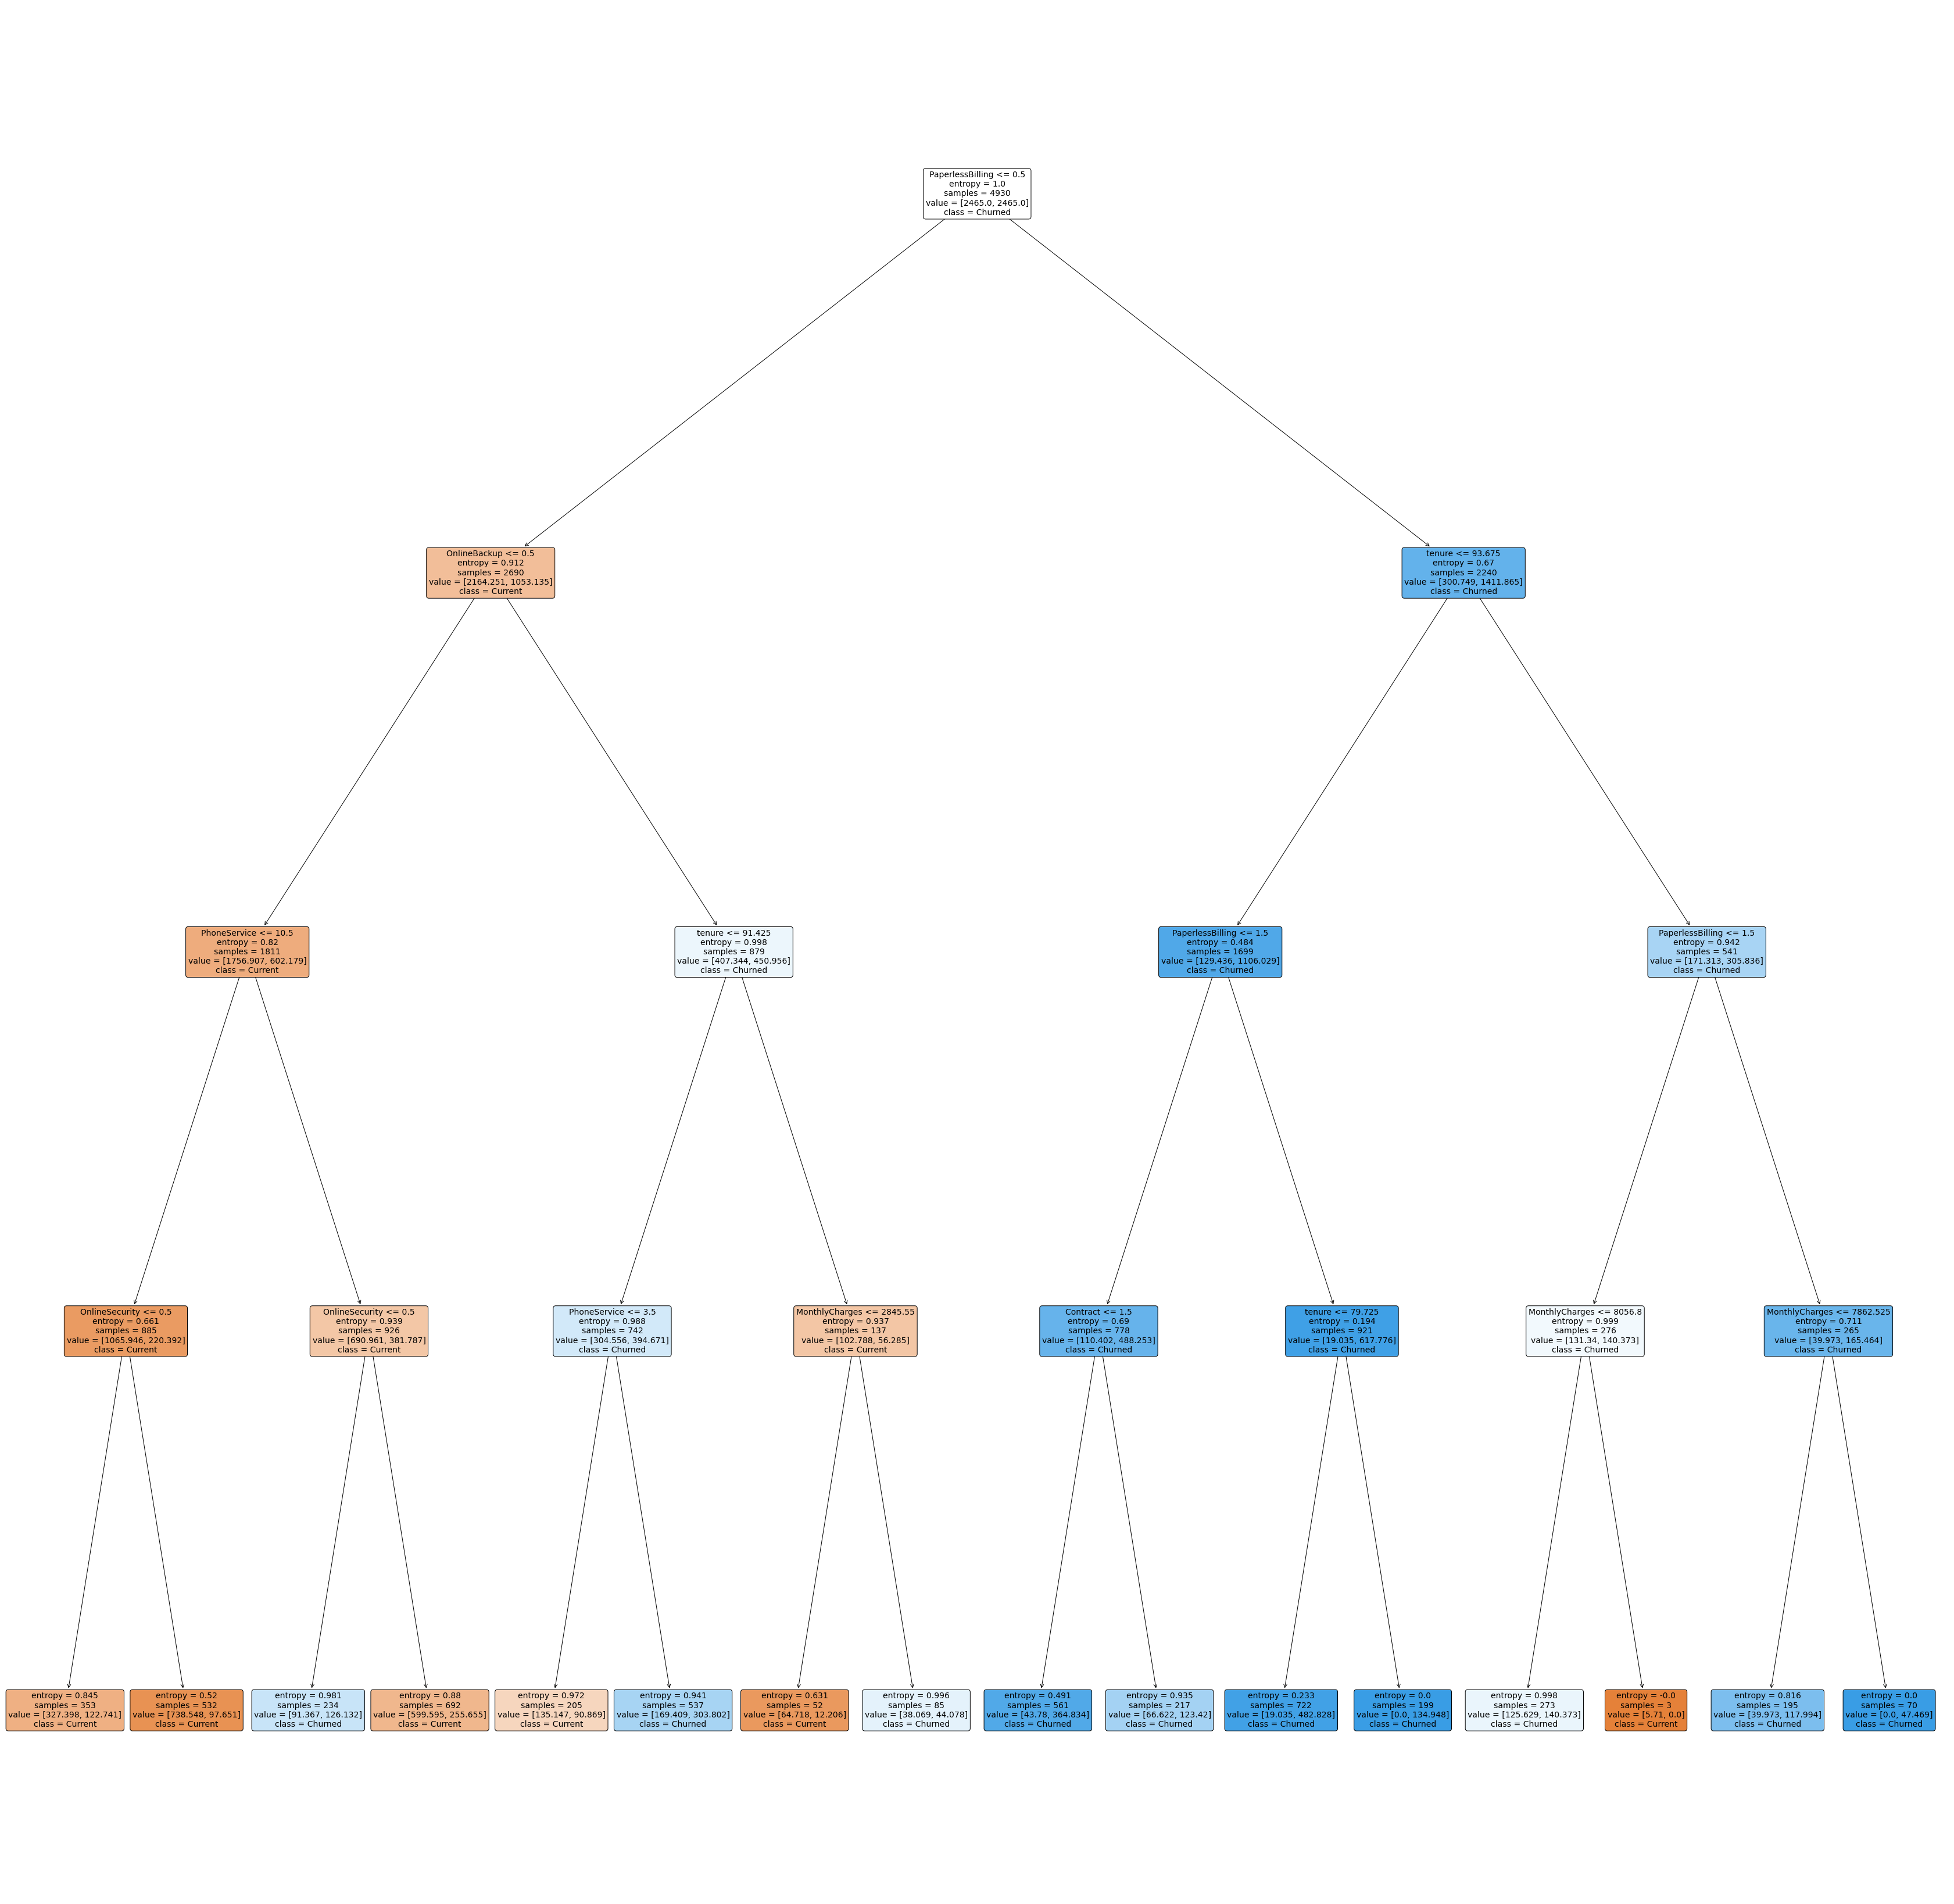

In [20]:
#plot visualization of the Decision tree
plt.figure(figsize=(60,60))
tree.plot_tree(r, 
              feature_names=categorical + numerical, 
              class_names= df['Churn'].unique(), 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

The above shows the decision tree, a png version is in project github to zoom in with. When looking at the tree there are a few parameters that make up a majority of the nodes, being Paperless Billing, Tenure, contract, monthly charges. then Online backup, PhoneServices, and Online Security making up a small number of nodes.

Though Tenure, Paperless Billing, contract type,Online Security & back up where expected to be impactful. features like monthly and total charges made a larger impact on the model than expected and features that looked like they would have a larger impact like payment methiod and internet service had what looks like to be none. 

Now that we have a trained and tested modal we can put together a plan to keep track and evaluate how the model performs moving forward as well as come up with some a/b tests that to potentially help reduce customer churn.

In addition to the prediction the model can produce the class probabilities of each input. Using the class probabilities may be more useful of a metric as they give us a gauge into the risk of these customers leaving. Because we can prevent churned customers from leaving we are only really interested in current customers. Below we remove churned customers from the test data set and run the new test data through the model to get the predictions and class probabilities from here we can categorise each data point based on the models estimated confidence in leaving. 


In [36]:
#creat new test data set
data = pd.concat([x_test, pd.DataFrame(y_test)], axis=1)
data = data[data['Churn'] == 'Current'].drop(columns=['Churn'])

In [37]:
 #predict class and probability 
ChurnPred = pd.DataFrame(r.predict(data)).rename(columns={ 0 : "prediction"})
ChurnEst = pd.DataFrame(r.predict_proba(data)).rename(columns={ 0 : "% to Churn"})

In [41]:
#merge predictions 
Pred = pd.concat([ChurnPred, ChurnEst], axis=1).drop(columns=1)

In [42]:
#create categorical values
Pred['Risk'] = ''
for index, row in Pred.iterrows():
    lvl = Pred.loc[index,"% to Churn"]
    if lvl > .85:
        Pred.loc[index,'Risk'] = 'Very High'
    elif lvl > .60:
        Pred.loc[index,'Risk'] = 'High'
    elif lvl > .40:
        Pred.loc[index,'Risk'] = 'Medium'
    else:
        Pred.loc[index,'Risk'] = 'Low'

In [43]:
Pred

,prediction,% to Churn,Risk
0,Current,0.357999,Low
1,Current,0.037928,Low
2,Current,0.037928,Low
3,Current,0.037928,Low
4,Current,0.037928,Low
...,...,...,...
1534,Churned,0.727326,High
1535,Current,0.037928,Low
1536,Current,0.037928,Low
1537,Churned,0.701076,High


In [44]:
#export predictions
Pred.to_csv('TestChurnPred.csv')